In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
weather = pd.read_csv('weather.csv')
weather.replace({'Precipitat': {'T': 0}}, inplace=True)
data['precipitation'] = np.repeat(weather.Precipitat.values.astype(float), 96, axis=0)[20:20+data.shape[0]]
data['temperature'] = np.repeat(weather.Temperat.values.astype(float), 96, axis=0)[20:20+data.shape[0]]

y = data.groupby('day_id')['gh'].mean().values
u = data.groupby('day_id')['precipitation'].mean().values
t = data.groupby('day_id')['temperature'].mean().values

In [4]:
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import r2_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LassoCV, RidgeCV

# Linear System Identification

In [5]:
p = 10
q = 5
r = 5
s = 10

X_GH = list()
y_train = list()
for i in range(max(p,q,r,s), y.size):
    X_GH.append(t[i-r:i].tolist() + u[i-q:i].tolist() + y[i-p:i].tolist())
    y_train.append(y[i])
X_GH = np.array(X_GH)
y_train = np.array(y_train)   

GH_lasso = LassoCV(tol=0.0001, n_alphas=100, max_iter=10000, cv=10, n_jobs=-1)
GH_ridge = RidgeCV(alphas=[2**i for i in range(-10,4)], cv=10)
GH_lasso.fit(X_GH, y_train)
GH_ridge.fit(X_GH, y_train)

y_pred = GH_ridge.predict(X_GH)
e = y_train - y_pred
print("Lasso R2 score: %.4f" % GH_lasso.score(X_GH, y_train))
print("Ridge R2 score: %.4f" % GH_ridge.score(X_GH, y_train))
print("Error 1-lag autocorrelation (Ridge): %.4f" % np.corrcoef(e[1:], e[:-1])[0,1])

v = abs(e)
X_VAR = list()
v_train = list()
for i in range(max(p,q,r,s), v.size):
    X_VAR.append(t[i-r:i].tolist() + u[i-q:i].tolist() + y[i-p:i].tolist() + v[i-s:i].tolist())
    v_train.append(v[i])
X_VAR = np.array(X_VAR)
v_train = np.array(v_train)   

VAR_lasso = LassoCV(tol=0.0001, n_alphas=100, max_iter=10000, cv=10, n_jobs=-1)
VAR_ridge = RidgeCV(alphas=[2**i for i in range(-10,4)], cv=10)
VAR_lasso.fit(X_VAR, v_train)
VAR_ridge.fit(X_VAR, v_train)

print("ARCH Lasso R2 score: %.4f" % VAR_lasso.score(X_VAR, v_train))
print("ARCH Ridge R2 score: %.4f" % VAR_ridge.score(X_VAR, v_train))

Lasso R2 score: 0.9794
Ridge R2 score: 0.9802
Error 1-lag autocorrelation (Ridge): -0.0043
ARCH Lasso R2 score: 0.1503
ARCH Ridge R2 score: 0.1508


# Simulation - impulse response

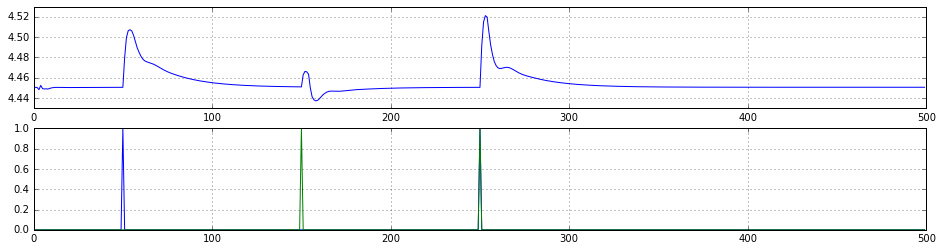

In [56]:
n = 500
t_sim = np.zeros(n)
u_sim = np.zeros(n)

u_sim[50] = 1
t_sim[150] = 1
u_sim[250] = 1
t_sim[250] = 1

y_sim = np.zeros(n)
y_sim[:10] = 4.45 + 0.001*np.random.randn(10)

for i in range(10,n):
    x = np.array(t_sim[i-r:i].tolist() + u_sim[i-q:i].tolist() + y_sim[i-p:i].tolist()).reshape(1,-1)
    y_sim[i] = max(0, GH_ridge.predict(x))
    
plt.figure(figsize=(16,4))
plt.subplot(2,1,1)
plt.plot(y_sim)
plt.grid()

plt.subplot(2,1,2)
plt.plot(u_sim)
plt.plot(t_sim)
plt.grid()

# Simulation - step response

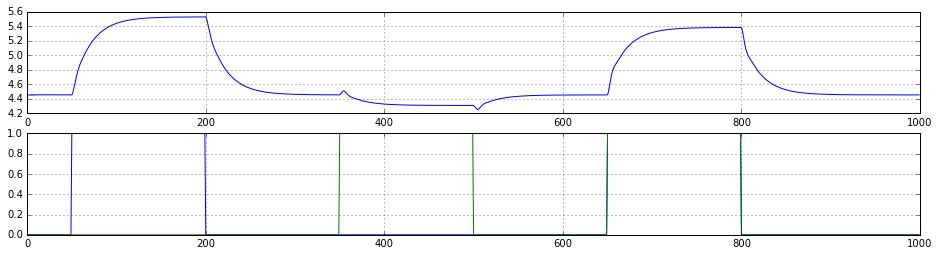

In [75]:
n = 1000
t_sim = np.zeros(n)
u_sim = np.zeros(n)

u_sim[50:200] = 1
t_sim[350:500] = 1
u_sim[650:800] = 1
t_sim[650:800] = 1

y_sim = np.zeros(n)
y_sim[:10] = 4.45 + 0.005*np.random.randn(10)

for i in range(10,n):
    x = np.array(t_sim[i-r:i].tolist() + u_sim[i-q:i].tolist() + y_sim[i-p:i].tolist()).reshape(1,-1)
    y_sim[i] = max(0, GH_ridge.predict(x))
    
plt.figure(figsize=(16,4))
plt.subplot(2,1,1)
plt.plot(y_sim)
plt.grid()

plt.subplot(2,1,2)
plt.plot(u_sim)
plt.plot(t_sim)
plt.grid()

# Simulation - noise response

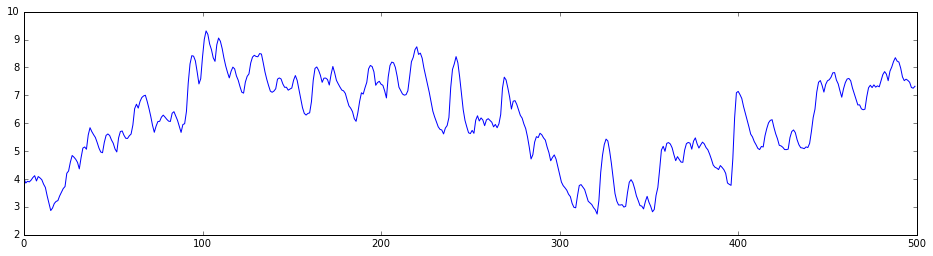

In [82]:
n = 500
t_sim = 15*np.sin(0.0173*np.arange(n) - 500) + 10 + 5*np.random.randn(n)
u_sim = np.random.exponential(6, n)
u_sim[u_sim < 10] = 0

y_sim = np.zeros(n)
y_sim[:10] = 4 + 0.1*np.random.randn(10)

for i in range(10,n):
    x = np.array(t_sim[i-r:i].tolist() + u_sim[i-q:i].tolist() + y_sim[i-p:i].tolist()).reshape(1,-1)
    y_sim[i] = max(0, GH_ridge.predict(x))
    
plt.figure(figsize=(16,4))
plt.plot(y_sim)

# Optimal Bi-directional Filter

In [24]:
p = 3
q = 2

n = max(p,q,r,s)
y_out = y.copy()
idx = np.random.choice(np.arange(y_out.size), int(0.015*y_out.size), replace=False)
y_out[idx] += np.median(y_out)

X = list()
z = list()
for i in range(n, y.size - n):
    X.append(y_out[i-p:i].tolist() + y_out[i+1:i+p+1].tolist() + \
             u[i-q:i].tolist() + u[i+1:i+q+1].tolist())
    z.append(y_out[i])
X = np.array(X)
z = np.array(z)   

gh_lasso = LassoCV(tol=0.0001, n_alphas=100, max_iter=10000, cv=10, n_jobs=-1)
gh_ridge = RidgeCV(alphas=[2**i for i in range(-10,4)], cv=10)
gh_lasso.fit(X, z)
gh_ridge.fit(X, z)

y_pred = gh_ridge.predict(X)
e = z - y_pred
print("Lasso R2 score: %.4f" % gh_lasso.score(X, z))
print("Ridge R2 score: %.4f" % gh_ridge.score(X, z))
print("Error 1-lag autocorrelation (ridge): %.4f" % np.corrcoef(e[1:], e[:-1])[0,1])

detected = z > y_pred + 3*np.std(e)
true = np.zeros(z_out.size - n, dtype=bool)
true[idx - n] = True

print("\nOutlier detection:")
print("Precision: %.4f" % precision_score(true, detected))
print("Recall: %.4f" % recall_score(true, detected))
print("F1_score: %.4f" % f1_score(true, detected))

Lasso R2 score: 0.9334
Ridge R2 score: 0.9335
Error 1-lag autocorrelation (ridge): -0.3919

Outlier detection:
Precision: 1.0000
Recall: 1.0000
F1_score: 1.0000
